# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science 


## Lab 5: Missing Data, Classification and Dimensionality Reduction 

**Harvard University**<br>
**Summer 2018**<br>
**Instructors:** Pavlos Protopapas and Kevin Rader<br>
**Lab Instructors:** Will Claybaugh and David Sondak

---

## <font color='red'> Run the cell below to properly highlight the exercises</font>

In [1]:
from IPython.display import HTML
style = "<style>"+\
    "div.exercise { background-color: #ffcccc;border-color: #E9967A; border-left: 5px solid #800080; padding: 0.5em;}"+\
    "div.discussion { background-color: #ffcccc;border-color: #E9967A; border-left: 5px solid #800080; padding: 0.5em;}"+\
    "</style>"
HTML(style)

## Learning Goals
In this lab, we'll explore different models used to predict which of several labels applies to a new datapoint based on labels observed in the training data. We'll similarly explore PCA as a technique for reducing the number of features in a dataset with as little loss of structure as possible.

By the end of this lab, you should:
- Be familiar with the `sklearn` implementations of
 - Logistic Regression
 - KNN Classifier
 - LDA and QDA
- Be able to make an informed choice of model based on the data at hand
- Be familiar with the SKlearn implementation of Principle Components Analysis (PCA)
- Be able to select an appropriate number of PCA components
- (Bonus) Structure your sklearn code into Pipelines to make building, fitting, and tracking your models easier
- (Bonus) Apply weights to each class in the model to achieve your desired tradeoffs between discovery and false alarm in various classes

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

from sklearn.model_selection import train_test_split

## Part 1:  The Wine Dataset
The dataset contains 11 chemical features of various wines, along with experts' rating of that wine's quality. The quality scale technically runs from 1-10, but only 3-9 are actually used in the data.

Our goal will be to distinguish good wines from bad wines based on their chemical properties.

### Read-in and checking
We do the usual read-in and verification of the data:

In [2]:
wines_df = pd.read_csv("data/wines.csv", index_col=0)

wines_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,good
0,8.9,0.590,0.50,2.0,0.337,27.0,81.0,0.99640,3.04,1.61,9.5,6,1,0
1,7.7,0.690,0.22,1.9,0.084,18.0,94.0,0.99610,3.31,0.48,9.5,5,1,0
2,8.8,0.685,0.26,1.6,0.088,16.0,23.0,0.99694,3.32,0.47,9.4,5,1,0
3,11.4,0.460,0.50,2.7,0.122,4.0,17.0,1.00060,3.13,0.70,10.2,5,1,0
4,8.8,0.240,0.54,2.5,0.083,25.0,57.0,0.99830,3.39,0.54,9.2,5,1,0


In [3]:
wines_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,good
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,7.558400,0.397455,0.30676,4.489250,0.067218,25.29650,91.03100,0.995351,3.251980,0.572990,10.489433,5.796000,0.50000,0.189000
std,1.559455,0.189923,0.16783,4.112419,0.046931,17.06237,59.57269,0.002850,0.164416,0.169583,1.151195,0.844451,0.50025,0.391705
min,3.800000,0.080000,0.00000,0.800000,0.009000,1.00000,6.00000,0.987400,2.740000,0.280000,8.500000,3.000000,0.00000,0.000000
25%,6.500000,0.260000,0.22000,1.800000,0.042000,12.00000,37.75000,0.993480,3.140000,0.460000,9.500000,5.000000,0.00000,0.000000
50%,7.200000,0.340000,0.30000,2.400000,0.060000,22.00000,86.00000,0.995690,3.240000,0.550000,10.300000,6.000000,0.50000,0.000000
75%,8.200000,0.520000,0.40000,6.100000,0.080000,35.00000,135.00000,0.997400,3.360000,0.650000,11.300000,6.000000,1.00000,0.000000
max,15.500000,1.580000,1.00000,26.050000,0.611000,131.00000,313.00000,1.003690,3.900000,2.000000,14.000000,8.000000,1.00000,1.000000


### Building the training/test data
As usual, we split the data before we begin our analysis.

Today, we take the 'quality' variable as our target. There's a debate to be had about the best way to handle this variable. It has 10 categories (1-10), though only 3-9 are used. While the variable is definitely ordinal- we can put the categories in an order everyone agrees on- the variable probably isn't a simple numeric feature; it's not clear whether the gap between a 5 and a 6 wine is the same as the gap between an 8 and a 9.

[Ordinal regression](https://pythonhosted.org/mord/) is one possibility for our analysis (beyond the scope of this course), but we'll view the quality variable as categorical. Further, we'll simplify it down to 'good' and 'bad' wines (quality at or above 7, and quality at or below 6, respectively). This binary column already exists in the data, under the name 'good'.

In [4]:
wines_train, wines_test = train_test_split(wines_df, test_size=0.2, random_state=8, stratify=wines_df['good'])

x_train = wines_train.drop(['quality','good'], axis=1)
y_train = wines_train['good']

x_test = wines_test.drop(['quality','good'], axis=1)
y_test = wines_test['good']

x_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red
744,7.6,0.30,0.37,1.6,0.087,27.0,177.0,0.99438,3.09,0.50,9.8,0
51,7.6,0.29,0.49,2.7,0.092,25.0,60.0,0.99710,3.31,0.61,10.1,1
213,13.2,0.46,0.52,2.2,0.071,12.0,35.0,1.00060,3.10,0.56,9.0,1
883,8.6,0.33,0.34,11.8,0.059,42.0,240.0,0.99882,3.17,0.52,10.0,0
98,7.7,0.41,0.76,1.8,0.611,8.0,45.0,0.99680,3.06,1.26,9.4,1


Now that we've split, let's explore some patterns in the data

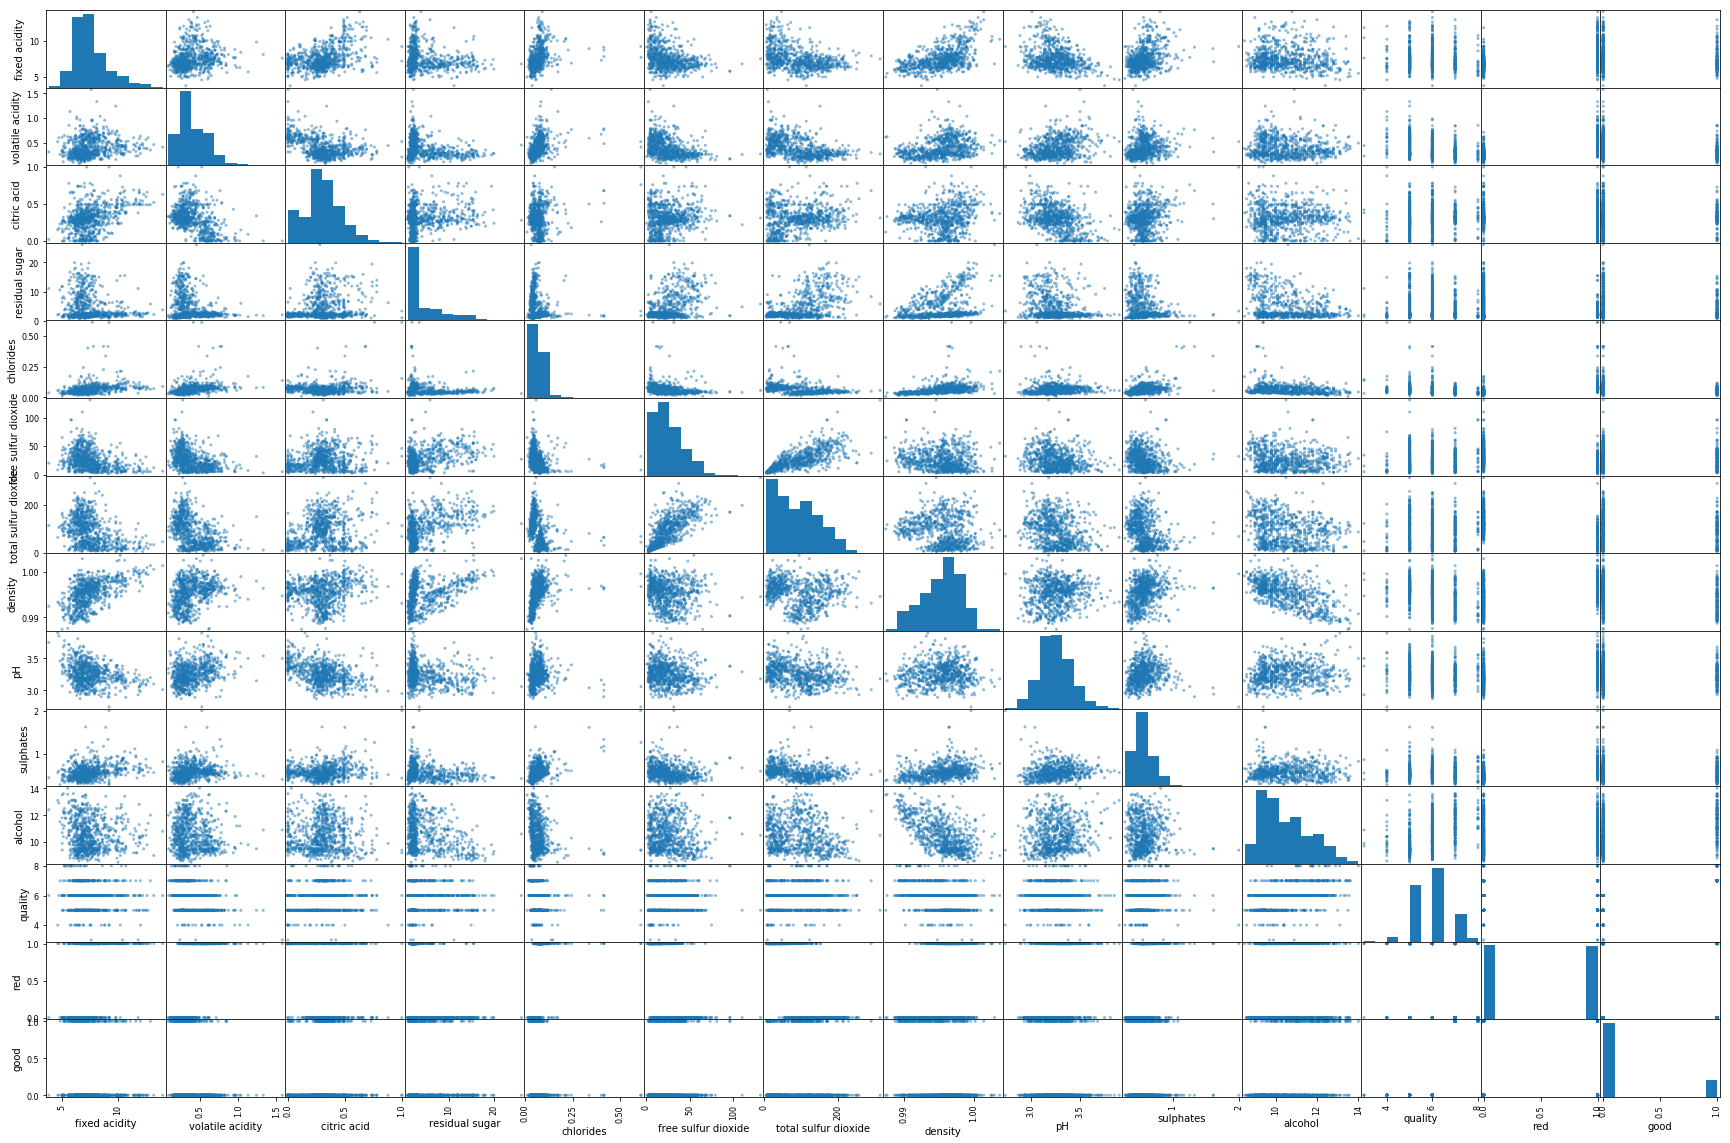

In [6]:
from pandas.plotting import scatter_matrix

scatter_matrix(wines_train, figsize=(30,20));

It looks like there aren't any particularly strong correlations among the predictors (maybe sulfur dioxide and free sulfur dioxide) so we're safe to keep them all. It also looks like the different quality categories have roughly the same distribution of most variables, with volatile/fixed acidity and alcohol seeming like the most useful predictors.

## Part 2 (Introduction): Binary Logistic Regression
Linear regression is usually a good baseline model, but since the outcome we're trying to predict only takes values 0 and 1 we'll want to use logistic regression instead of basic linear regression.

We'll begin with `statsmodels`, because `cs109` likes confidence intervals and checking that coefficients make sense.

In [7]:
import statsmodels.api as sm
sm_fitted_logit = sm.Logit(y_train, sm.add_constant(x_train)).fit()
#sm_fitted_logit.summary() ### ORIGINAL VERSION.  GAVE AttributeError: module 'scipy.stats' has no attribute 'chisqprob'
sm_fitted_logit.summary2() ### WORKS

Optimization terminated successfully.
         Current function value: 0.372167
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:                  Logit              Pseudo R-squared:   0.232     
Dependent Variable:     good               AIC:                621.4673  
Date:                   2018-07-29 12:42   BIC:                682.3672  
No. Observations:       800                Log-Likelihood:     -297.73   
Df Model:               12                 LL-Null:            -387.52   
Df Residuals:           787                LLR p-value:        5.1997e-32
Converged:              1.0000             Scale:              1.0000    
No. Iterations:         10.0000                                          
-------------------------------------------------------------------------
                       Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-------------------------------------------------------------------------
const                 296.7882 178.7587  1.6603 0.0969  -53.5724 647.1488
fixed acidity           0.4228   0.1962  2.1546 0.0312    0.0382   0.8073
volatile acidity       -3.6301   1.1006 -3.2983 0.0010   -5.7872  -1.4729
citric acid            -0.8217   1.0638 -0.7724 0.4399   -2.9066   1.2633
residual sugar          0.1628   0.0759  2.1454 0.0319    0.0141   0.3115
chlorides             -18.8903   8.1523 -2.3172 0.0205  -34.8684  -2.9121
free sulfur dioxide     0.0026   0.0089  0.2864 0.7746   -0.0150   0.0201
total sulfur dioxide   -0.0036   0.0038 -0.9597 0.3372   -0.0110   0.0038
density              -312.9457 182.0829 -1.7187 0.0857 -669.8215  43.9302
pH                      1.5112   1.1276  1.3402 0.1802   -0.6989   3.7212
sulphates               2.5571   0.8610  2.9700 0.0030    0.8696   4.2446
alcohol                 0.4945   0.2190  2.2580 0.0239    0.0653   0.9236
red                     0.6751   0.6490  1.0403 0.2982   -0.5968   1.9470
=========================================================================

"""

Let's talk about the output:  
First, "optimization terminated successfully". Recall that linear regression and its simple formula for the optimal betas is a rarity in machine learning and statistics: most models are fit to the data algorithmically, not via a formula. This message is letting us know that the algorithm seems to have worked.

Second, the pseudo $R^2$ is rather low (.23). As with regular $R^2$, we might take this as a sign that the model is struggling.

Finally, let's look at the coefficients. 
 - Several of the coefficients are statistically significant, including
    - Fixed acidity - good
    - Volatile Acidity - bad
    - Residual Sugar - good (judge have a sweet tooth?)
    - Chlorides - bad
    - Sulphates - good
    - Alcohol - good (judges like getting drunk?)
    - The rest only reach a coefficient size we would often observe by chance alone, without any actual effect from the predictor

     
More formal interpretations are of coefficients are long-winded. "A one unit increase in alcohol (holding all else constant) results in a predicted 0.494 increase in the log odds of a wine being classified as good".

We can't be more precise because the effect of one unit of alcohol depends on how much alcohol there already is. The one unit increase/decrease matters more if the wine is otherwise on the border between good and bad. If the wine is undrinkable (in the far left tail of the sigmoidal curve) one unit of alcohol barely moves the probability, while if the wine is in the middle of the curve that unit of acidity has much more practical impact.

<div class="discussion"><b>Discussion</b></div>
1. Are there any bones you'd like to pick with the model I've laid out? Can you think of a better logistic regression model?<BR><BR>
Ans: Values are linear. More sugar is good, but too much sugar is bad. <BR>
    Interaction terms aren't considered. Sugar and alcohol combination might mean something. <BR>
    Judge's priorities might not be mine.

#### Prediction
One of the really cool features of logistic regression is that it hands back _probabilities_ of a given case being 1 or 0, rather than just 1s and 0s. That lets us do neat things like set different cutoffs for what counts as a 1 and do ROC analysis and so on. Here, we'll just set the cutoff at 0.5: if a 1 is reported as more likely, predict a 1. (You can play with the cutoff yourself and see if you can make the model do better by trading false positives and false negatives).

Because this is statsmodels, we'll need to import a tool or do the test set score calculation ourselves. Here, it's easy enough to implement: 
* do the predictions
* compare with .5
* find out what percentage of our binary predictions matched the truth

In [8]:
sm_binary_prediction = sm_fitted_logit.predict(sm.add_constant(x_test)) >= .5
np.sum(y_test == sm_binary_prediction) / len(y_test)

0.805

Wow! 80% is a pretty good performance! We can pretty much tell the bad wines from the good.

Here's a sanity check:

In [9]:
np.sum(y_test == 0) / len(y_test)

0.81

Oh... no... wait. A model that says "all wines are bad" also scores 80% on the test set. Our fancy model isn't really doing that well.

**Moral of the story**: Before you congratulate a model, think of a **truly** trivial model to compare it to.

<div class="exercise"><b>Exercise 1</b></div>

1. Re-create the results above but this time work with `sklearn`.  Use the `LogisticRegression` class. Follow the usual `.fit`, `.score` procedure.  To match `statsmodel`'s coefficient values (roughly), you will need to adjust the input parameters:
  * `C`
  * `solver`
  * One other parameter
  * See [the sklearn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Hint: `statsmodels` uses a Newton-Raphson method to optimize the beta values.

In [55]:
from sklearn.linear_model import LogisticRegression
print("target:\n{}".format(sm_fitted_logit.params))

# your code here
fitted_lr = LogisticRegression(C=10000000, solver='newton-cg', max_iter=250).fit(x_train, y_train)

print(fitted_lr.coef_)
print('Test set score: {0}'.format(fitted_lr.score(x_test, y_test)))

target:
const                   296.788181
fixed acidity             0.422755
volatile acidity         -3.630081
citric acid              -0.821665
residual sugar            0.162801
chlorides               -18.890258
free sulfur dioxide       0.002563
total sulfur dioxide     -0.003620
density                -312.945669
pH                        1.511186
sulphates                 2.557134
alcohol                   0.494461
red                       0.675074
dtype: float64
[[ 4.21553421e-01 -3.63106865e+00 -8.21559721e-01  1.62274921e-01
  -1.89027238e+01  2.56687971e-03 -3.62261040e-03 -3.11554573e+02
   1.50541742e+00  2.55451537e+00  4.95903360e-01  6.72543894e-01]]
Test set score: 0.805


#### The Decision Boundary
One powerful way to think about classification models is to consider where and how they draw the line between predicting "class A" and "class B". The code below lets you play with a 2d logistic regression. Points towards yellow will be predicted as 1s, points towards violet will be predicted as 0s.

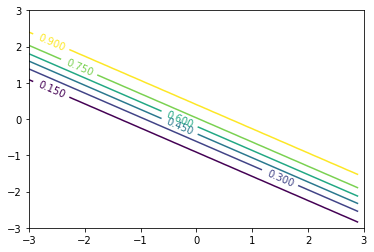

In [56]:
from scipy.special import expit

def plot_logistic_contour(beta0, betaX, betaY, betaXY=0, betaX2=0, betaY2=0):
    delta=.1
    x_values = np.arange(-3.0, 3.0, delta)
    y_values = np.arange(-3.0, 3.0, delta)
    x_grid, y_grid = np.meshgrid(x_values, y_values)

    logistic_output = expit(beta0 + betaX*x_grid + betaY*y_grid 
                            + betaXY*x_grid*y_grid + betaX2*x_grid**2 + betaY2*y_grid**2)

    contour_figure = plt.contour(x_grid, y_grid, logistic_output)
    plt.clabel(contour_figure, inline=1, fontsize=10);
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.show()
    
plot_logistic_contour(beta0=1, betaX=2, betaY=3)

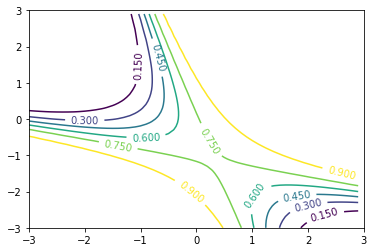

In [78]:
# Use this cell to experiment
plot_logistic_contour(beta0=1, betaX=2, betaY=0.5, betaXY=2, betaX2=0.5, betaY2=0.5)

<div class="exercise"><b>Exercise 2</b></div>
1. What happens to the decision boundary as the coefficient on X increases? -> Y intercept increases
2. What happens if you increase the Y coefficient to match? -> X intercept increases
3. What does the constant term control? -> Parallel movement of the line
4. What impact do higher-order and interaction terms have on the boundary? -> Higher order adds curved boundaries, interaction seem to change angle. Decimal values make it interesting 
5. What parameter settings should I show the class?

## Part 3 (The Real Challenge): Multiclass Classification
Before we move on, let's consider a more common use case of logistic regression: predicting not just a binary variable, but what level a categorical variable will take. Instead of breaking the quality variable into 'good' and 'other', let's discretize into 'good, 'medium', and 'bad'.

In [80]:
# copy the original data so that we're free to make changes
wines_df_recode = wines_df.copy()

# use the 'cut' function to reduce a variable down to particular bins. Here the lowest bin is 0-4, next is 5-7,
# and the last is 7-10
wines_df_recode['quality'] = pd.cut(wines_df_recode['quality'],[0,4,7,10], labels=[0,1,2])

# drop the un-needed columns
x_data = wines_df_recode.drop(['quality','good'], axis=1)
y_data = wines_df_recode['quality']

x_train,x_test, y_train,y_test = train_test_split(x_data, y_data, test_size=.2, random_state=8, stratify=y_data)

print(wines_df['quality'].head())
print(wines_df_recode['quality'].head())

0    6
1    5
2    5
3    5
4    5
Name: quality, dtype: int64
0    1
1    1
2    1
3    1
4    1
Name: quality, dtype: category
Categories (3, int64): [0 < 1 < 2]


The `cut` function obviously stores a lot of extra information for us. It's a very useful tool for discretizing an existing variable.

<div class="exercise"><b>Exercise 3</b></div>
1. Adapt your earlier logistic regression code to fit to the new training data. What is stored in `.coef_` and `.intercept_`?
2. How well does this model predict the test data?
3. Put the model's performance in context. Think of a trivial model to compare to, and provide its accuracy score on the test set.

In [96]:
fitted_lr = LogisticRegression(C=10000000, solver='newton-cg', max_iter=250).fit(x_train, y_train)

print(fitted_lr.intercept_)
print(fitted_lr.coef_)
print('There are three sets of boundary intercepts and coefficients. Each draws a boundary between each class \n i.e. bad and the others, then medium and the others and then good and the others \n')

print('Model test set score: {0}'.format(fitted_lr.score(x_test, y_test)))
print(('Everything is medium baseline model score: {0}').format(np.sum(y_test == 1) / len(y_test)))

[ 226.23846546 -414.11496302  309.99181834]
[[ 6.23555741e-01  5.45885649e+00 -1.39523330e+00  4.59168695e-02
   5.97325253e+00 -2.71526392e-02 -9.46788386e-03 -2.44744190e+02
   4.85140475e+00  2.70400252e+00 -7.05241651e-01 -4.45006246e+00]
 [-5.49805641e-01 -3.97165882e+00  7.44068742e-01 -8.09459940e-02
  -2.68544755e+00 -9.49843044e-03  8.63965011e-03  4.35869097e+02
  -4.40653570e+00 -3.16216015e+00  3.67302170e-01  2.56177345e+00]
 [ 1.89629490e-01 -3.66148906e+00  4.68043158e-01  7.10602442e-02
  -5.22402966e+01  2.84927122e-02 -1.37865057e-03 -3.28457078e+02
   2.89894665e+00  1.87297073e+00  2.53645156e-01  1.77838936e+00]]
There are three sets of boundary intercepts and coefficients. Each draws a boundary between each class 
 i.e. bad and the others, then medium and the others and then good and the others 

Model test set score: 0.945
Everything is medium baseline model score: 0.945


#### Summary
- Logistic regression extends OLS to work naturally with a dependent variable that's only ever 0 and 1.
- In fact, Logistic regression is even more general and is used for predicting the probability of an example belonging to each of $N$ classes.
- The code for the two cases is identical and just like `LinearRegression`: `.fit`, `.score`, and all the rest
- Significant predictors does not imply that the model actually works well. Signifigance can be driven by data size alone.
- The data aren't enough to do what we want

**Warning**: Logistic regression _tries_ to hand back valid probabilities. As with all models, you can't trust the results until you validate them- if you're going to use raw probabilities instead of just predicted class, take the time to verify that if you pool all cases where the model says "I'm 30% confident it's class A" 30% of them actually are class A.

## Part 4 (Model Menagerie): LDA and QDA
Let's move on to another classifier to see if we can perhaps do better than our poor results so far.

Linear Discriminant Analysis and Quadratic Discriminant Analysis assume that each 'good wine' comes from a Gaussian distribution with a particular center and spread, each 'bad wine' comes from another Gaussian distribution with a particular center and spread, and so on. Basically, the models suppose that each time a row of data is added, God plays dice to decide if it's good, bad, or medium wine, and then draws the wine's particular details from the matching Gaussian cloud.

LDA assumes the spread of each group is the same, and so the borders between "predict A" and "predict B" are straight lines. QDA allows the spread of each group to be different, and so enables curvy borders between "predict A" and "predict B". LDA can be advantageous when we have limited data with which to estimate a class's covariance matrix.

<div class="discussion"><b>Discussion</b></div>
1. Based on the summaries and scatter plots of the different variables, which of LDA and QDA seems more appropriate for the full data?
2. What additional plot or data would be helpful to make the choice between LDA and QDA?

<div class="exercise"><b>Exercise 4</b></div>
1. Build the plot(s) that we just discussed.

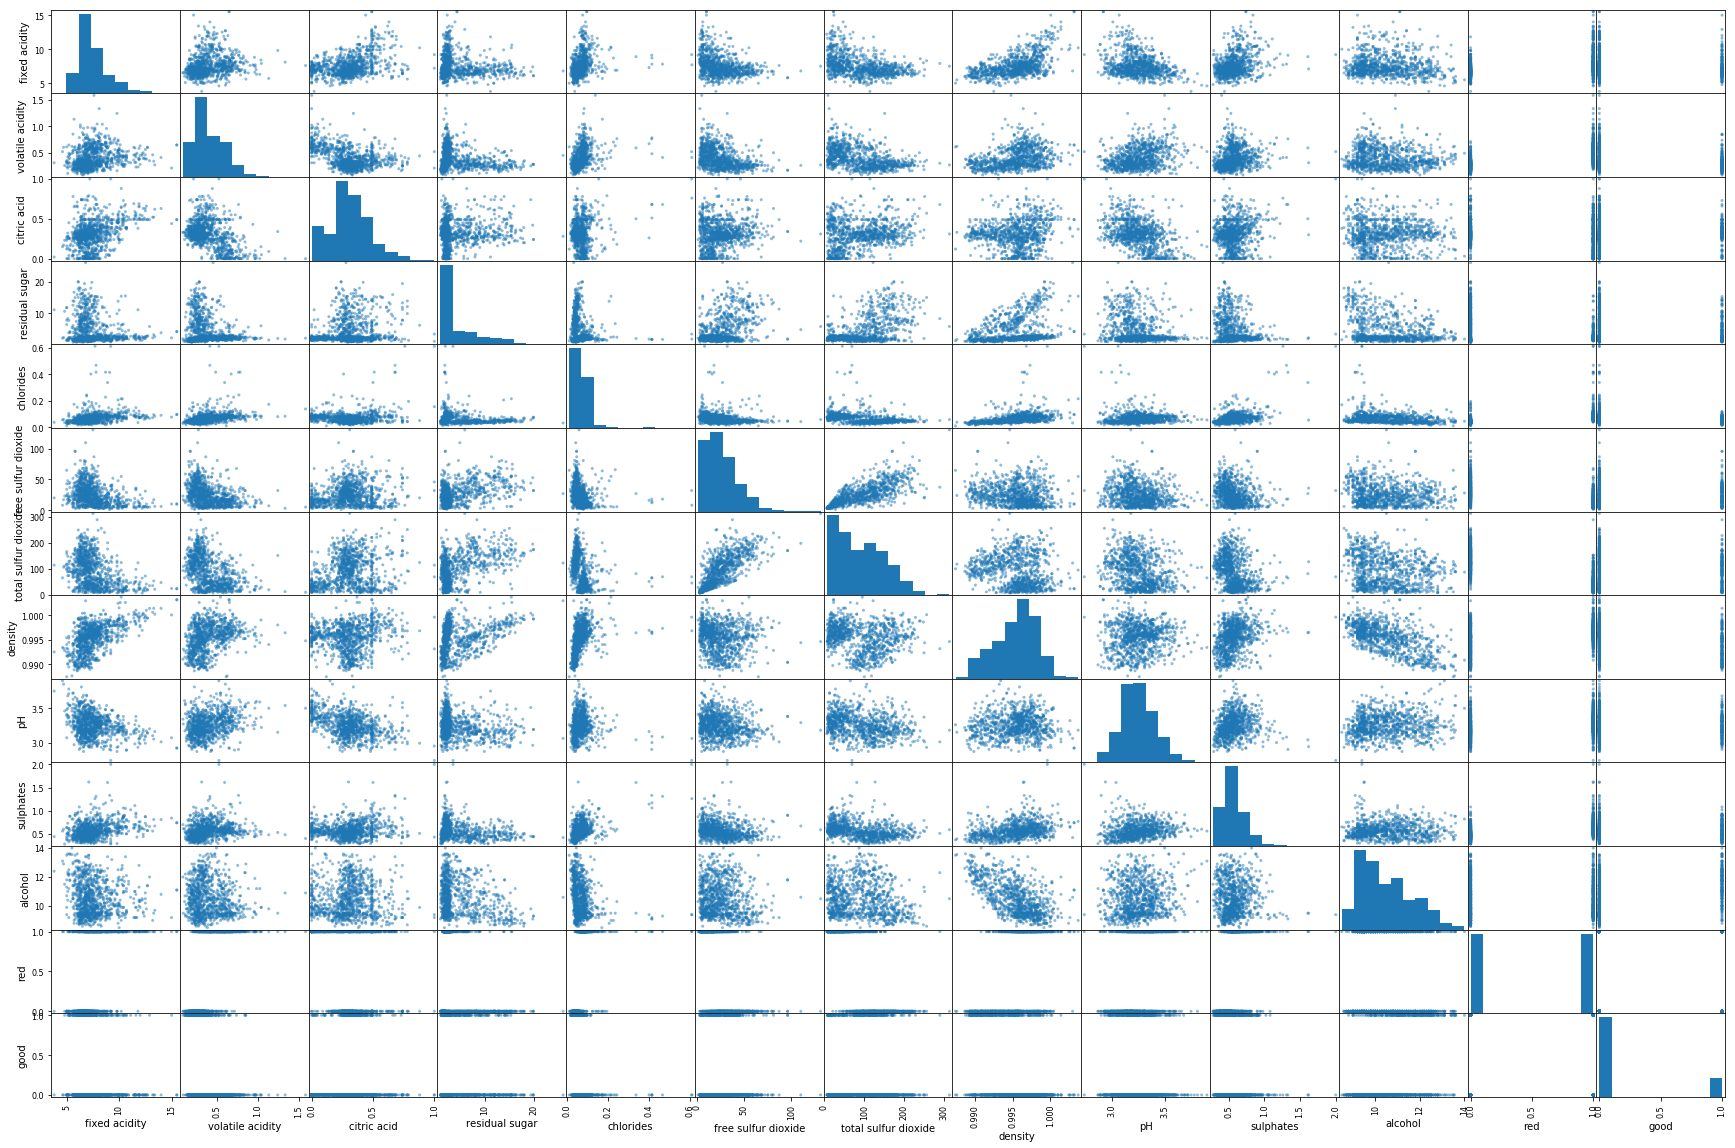

In [113]:
cat0 = wines_df_recode[wines_df_recode['quality']==0]
cat1 = wines_df_recode[wines_df_recode['quality']==1]
cat2 = wines_df_recode[wines_df_recode['quality']==2]

scatter_matrix(wines_df_recode, figsize=(30,20));

### Fitting LDA and QDA

In [114]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

fitted_lda = LinearDiscriminantAnalysis().fit(x_train, y_train)
#fitted_qda = QuadraticDiscriminantAnalysis().fit(x_train, y_train)

print("Model Test Set Score:", fitted_lda.score(x_test, y_test))

# make a dumb prediction that always guesses 1, the most common class
dumb_prediction = np.ones(len(y_test))
print("Trivial Test Set Score:", np.sum(y_test == dumb_prediction)/len(y_test))

Model Test Set Score: 0.925
Trivial Test Set Score: 0.945


Once again, the model struggles to do better than a trivial model

## Part 4 (Model Menagerie): KNN classification
Perhaps our difficulty is coming from our modeling assumptions-- logistic regression and LDA/QDA are optimal for data generated by a particular process and struggle to varying degrees on data from outside that realm. What if we turn to KNN, which doesn't assume anything about the data-generating process?

Classification for KNN is an easy modification of the original algorithm: instead of averaging the y-value of the neighbors, we have them vote in some way on what the trial point should be classified as. Often, the voting rule is a simple majority.

In [115]:
from sklearn.neighbors import KNeighborsClassifier

fitted_2_neighbors = KNeighborsClassifier(n_neighbors = 2).fit(x_train, y_train)
fitted_2_neighbors.score(x_test,y_test)

0.89

<div class="exercise"><b>Exercise 5</b></div>
Here, we saw that a 2-NN model doesn't do so well. Pretending we haven't already cheated by using the test data, do the following:
1. Get the performance estimates from a 3-fold cross validation for a 3 nearest-neighbors model.
2. Repeat part 1 of this exercise for $k$ from 1 through 10 by wrapping the code in a loop (use `enumerate`!).  Store the results from each fold in a 3-column data frame. Include a row for each $k$ value between 1 and 10.
3. Suggest a good value of $k$ and evaluate it on the test set.

In [145]:
from sklearn.model_selection import cross_val_score

cross_val_score(KNeighborsClassifier(n_neighbors = 3), x_train, y_train, cv=3)

array([0.92537313, 0.92857143, 0.92481203])

In [149]:
results = np.zeros((10,3))
for i,n in enumerate(range(1,11)):
    model = KNeighborsClassifier(n_neighbors = n)
    results[i,:] = cross_val_score(model, x_train, y_train, cv=3)

results_df = pd.DataFrame(results, index=list(range(1,11)), columns= ["CV1","CV2","CV3"])
results_df['meanCV'] = np.mean(results, axis=1)

results_df

,CV1,CV2,CV3,meanCV
1,0.921642,0.890977,0.898496,0.903705
2,0.899254,0.898496,0.879699,0.892483
3,0.925373,0.928571,0.924812,0.926252
4,0.925373,0.936090,0.928571,0.930012
5,0.940299,0.943609,0.939850,0.941252
6,0.940299,0.943609,0.939850,0.941252
7,0.940299,0.943609,0.943609,0.942506
8,0.940299,0.943609,0.943609,0.942506
9,0.940299,0.943609,0.943609,0.942506
10,0.940299,0.943609,0.943609,0.942506


In [150]:
fitted_7_neighbors = KNeighborsClassifier(n_neighbors = 7).fit(x_train, y_train)
fitted_7_neighbors.score(x_test,y_test)

0.94

#### Summary
- Logistic regression: Adapt OLS to estimate the probability that a given example comes from each class.
- LDA: Assume that each class's data come from a specific Gaussian cloud; more powerful and than logistic regression if the assumption is true.
- QDA: Relax LDA to let each Gaussian cloud have a different spread; more data-intensive than LDA.
- KNN: Adapt KNN to guess class membership (typically via a majority vote of the neighbors).

## Part 5: Dimensionality Reduction
Our models are clearly struggling, but it's hard to tell why. Let's PCA to shrink the problem down to 2d (with as little loss as possible) and see if that gives us a clue about what makes this problem tough.

In [151]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# scale the datasets
scale_transformer = StandardScaler(copy=True).fit(x_train)
x_train_scaled = scale_transformer.transform(x_train)
x_test_scaled = scale_transformer.transform(x_test)


# reduce dimensions
pca_transformer = PCA(2).fit(x_train_scaled)
x_train_2d = pca_transformer.transform(x_train_scaled)
x_test_2d =  pca_transformer.transform(x_test_scaled)

x_train_2d[0:5,:]

array([[-2.63443953,  2.35110525],
       [-2.01816506,  0.17686554],
       [ 1.05494434,  1.0011009 ],
       [-2.7683873 ,  0.46852937],
       [ 2.35687171, -0.26731517]])

Some comments:
1. Both scaling and reducing dimension follow the same pattern: we fit the object to the training data, then use .transform to convert the training and test data. This ensures that, for instance, we scale the test data using the _training_ mean and variance, not its own mean and variance
2. We need to equalize the variance of each feature before applying PCA, otherwise certain dimensions will dominate the scaling: our PCA dimensions would just be the features with the largest spread.

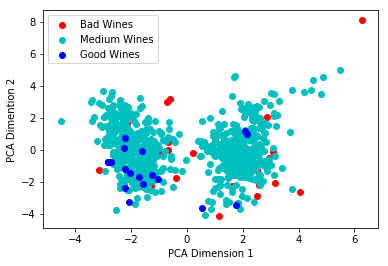

In [152]:
## plot each group

# notice that we set up lists to track each group's plotting color and label
colors = ['r','c','b']
label_text = ["Bad Wines", "Medium Wines", "Good Wines"]

# and we loop over the different groups
for cur_quality in [0,1,2]:
    cur_df = x_train_2d[y_train==cur_quality]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_quality], label=label_text[cur_quality])
    
# all plots need labels
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")
plt.legend();

Well, that gives us some idea of why the problem is difficult: the good wines and bad wines are hiding right among the average wines. It does look like the wines separate into two groups, though, possibly one for reds and one for whites.

<div class="discussion"><b>Discussion</b></div>
1. What critique can you make against the plot above? Why does this plot not prove that the different wines are hopelessly similar?
2. Which of LDA/QDA would be appropriate to this 2d data?
3. The wine data we've used so far consist entirely of continuous predictors. Would PCA work with categorical data?

<div class="exercise"><b>Exercise 6</b></div>
1. Edit the code above to plot the locations of red wines and white wines
2. Fit an LDA or QDA (whichever is appropriate) to the 2d data, classifying the red and white wines. Remember to compare to a trivial model.
3. Something is technically wrong with the fit above... If you have time, identify and correct it.

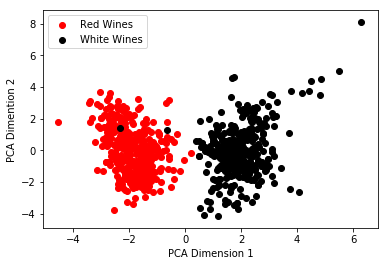

In [166]:
colors = ['r','black']
label_text = ["Red Wines", "White Wines"]

# and we loop over the different groups
for cur_color in [0,1]:
    cur_df = x_train_2d[x_train['red']==cur_color]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_color], label=label_text[cur_color])
    
# all plots need labels
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")
plt.legend();

### Evaluating PCA -  Variance Explained
One of the criticisms we made of the PCA plot was that it's lost something from the original data.

Let's actually investigate how much of the original data's structure the 2d PCA captures. We'll look at the `explained_variance_ratio_` portion of the PCA fit. This lists, in order, the percentage of the x data's total variance that is captured by the nth PCA dimension.

In [ ]:
var_explained = pca_transformer.explained_variance_ratio_
print("Variance explained by each PCA component:", var_explained)
print("Total Variance Explained:", np.sum(var_explained))

The first PCA dimension captures 33% of the variance in the data, and the second PCA dimension adds another 20%. Together, we've got about half of the total variation in the training data covered with just these two dimensions.

<div class="exercise"><b>Exercise 7</b></div>
1. Fit a PCA that finds the first 10 PCA components of our training data
2. Use `np.cumsum` to print out the variance we'd be able to explain by using n PCA dimensions for n=1 through 10
3. Does the 10-dimension PCA agree with the 2d PCA on how much variance the first components explain? Do the 10d and 2d PCAs find the same first two dimensions? Why or why not?
4. Make a plot of number of PCA dimensions against total variance explained. What PCA dimension looks good to you?

Hint: `np.cumsum` stands for 'cumulative sum', so `np.cumsum([1,3,2,-1,2])` is `[1,4,6,5,7]`

#### Summary
- PCA maps a high-dimensional space into a lower dimensional space.
- The PCA dimensions are ordered by how much of the original data's variance they capture
    - There are other cool and useful properties of the PCA dimensions (orthogonal, etc.). See a [textbook](http://math.mit.edu/~gs/linearalgebra/).
- PCA on a given dataset always gives the same dimensions in the same order.
- You can select the number of dimensions by fitting a big PCA and examining a plot of the cumulative variance explained.

## Part 6: Did we fail?
None of the models worked, and we can't tell good wines from bad. Was it all a waste of time and money?

Not really. All analyses are a roll of the dice. Some analyses fail, like this one did, becuase the data at hand just don't support the task we've set out.

What can we do about it?
1. Be honest about the methods and the null result. Lots of analyses fail.
2. Collect a dataset you think has a better chance of success. Maybe we collected the wrong chemical signals...
3. Keep trying new approaches. Just beware of overfitting the data you're validating on. Always have a test set locked away for when the final model is built.
4. Change the question. Maybe something you noticed during analysis seems interesting or useful (classifying red versus white). But again, you the more you try, the more you might overfit, so have test data locked away.
5. Just move on. If the odds of success start to seem small, maybe you need a new project.

#### The Moral of the Lab
- Sometimes, the data just aren't enough to adequately predict outcomes.
- In this lab we saw that no amount of modeling finesse would let us use a wine's chemical properties to tell good wines and bad wines from mediocre ones.
    - The chemical properties were very good at telling red wines from whites, however.
- PCA helped us visualize the data and confirm that the highly rated wines just aren't chemically distinct from the other wines.
- **NOT ALL ANALYSES YIELD USEFUL RESULTS** Sometimes (arguably most of the time), the data aren't suitable for a task or just don't have anything interesting to say.

## Part 7 (Sidebar): Pipelines
Remember when we were trying to adapt our LDA model to run on the training data with 'red' dropped? We had to invent new variable names and define functions and it was generally much harder than it needed to be. Pipelines are `sklearn`'s tool for packaging an entire analysis together into a single object. This enables convenient inspection, saving, deployment, and (yes) cross validation of the model.

Let's look at an example (we'll switch the model to KNN to justify some later analysis).

In [ ]:
from sklearn.pipeline import Pipeline
knn_pipeline = Pipeline(
    [
        ('scaling', StandardScaler()), # scale all columns
        ('dim_reduction', PCA()), # PCA to reduce dimension
        ('model', KNeighborsClassifier()) # KNN to predict
    ]
)


# run with default settings ()
knn_pipeline.fit(x_train, y_train)
print("Test set score (default parameters)", knn_pipeline.score(x_test, y_test))

# particular sub-component settings are accessed with the component name, two
# underscores, and the parameter name
knn_pipeline.set_params(dim_reduction__n_components = 2, model__n_neighbors = 5)
knn_pipeline.fit(x_train, y_train)
print("Test set score (updated parameters)", knn_pipeline.score(x_test, y_test))

There's also a convenience function `make_pipeline` that lets us skip naming the different steps. Notice the default names are all-lowercase versions of the class names (standardscaler, pca, kneighborsclassifier)

In [ ]:
from sklearn.pipeline import make_pipeline
knn_pipeline = make_pipeline(StandardScaler(), PCA(), KNeighborsClassifier())
knn_pipeline

It's easy to run the whole modelling process on new data:

In [ ]:
red_model = knn_pipeline.fit(x_train.drop('red', axis=1), x_train['red'])
red_model.score(x_test.drop('red', axis=1), x_test['red'])

As promised, cross validation tools work directly with the pipeline object.

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(knn_pipeline, x_train, y_train, cv=3)

In [ ]:
from sklearn.model_selection import GridSearchCV
search_dict = {
    'pca__n_components': [3,5,10],
    'kneighborsclassifier__n_neighbors': [1,2,3,4,5]
}
cv_results = GridSearchCV(knn_pipeline, search_dict, cv=3).fit(x_train, y_train)
cv_results.best_params_ 

**Note**: In general, more PCA components will work better for prediction. However, KNN often performs worse as dimension increases, meaning there may be a meaningful balance point between capturing more variance and a space small enough for KNN to work well.

## Part 8 (Sidebar): Weighting the training points
Some models can accept weights on the training points to given them greater priority in the model's fitting process. This can be useful if, for instance, certain classes are rare but we want to be sure the model classifies them correctly (e.g. we're trying to classify cancers and one form is rare but very aggressive). In general, weighting training points is like moving along the ROC curve; we change some model parameters to alter the mistakes the model makes to be more in line with our tastes.

Let's see this in action with a logistic regression:

In [ ]:
unweighted_lr = LogisticRegression(C=1000000).fit(x_train,y_train)

weight_dict = {0:100, 1:1, 2:100}
weighted_lr = LogisticRegression(C=1000000, class_weight=weight_dict).fit(x_train,y_train)

In [ ]:
from sklearn.metrics import confusion_matrix

print("Rows: True Lables (Bad, Medium, Good), \nColummns: Predicted Lables (Bad, Medium, Good)")
print()
print("unweighted:")
print(confusion_matrix(y_test, unweighted_lr.predict(x_test)))
print("weighted:")
print(confusion_matrix(y_test, weighted_lr.predict(x_test)))

Without weighting, the model plays it safe and predicts that all of the test set wines are medium. With weighting, the model is told to care more about getting the bad and good wines right. The model does as we've asked and correctly IDs 3 good/bad test wines, at the price of 17 falsely bad wines and 16 falsely good wines. However, if identifying bad and good wines is, as implied, 100 times more important than identifying medium wines, we've made a really good trade.


<div class="exercise"><b>Exercise 8</b></div>
1. What happens if you give a weight of 0 to the medium wines?
2. What weighting gives results that accord with your personal sense of what the model should be doing? How many actually-medium bottles is a single good bottle worth?